## Example analysis

This notebook shows how to visualize the receptive fields obtained from raw data by reverse correlation analysis (as e.g. following the method proposed in __test_analysis_photodiode.ipynb__).

Here, we use the _Drosophila_ medullary interneuron Mi4 as an example. The file **data/Mi4_fly12_acq1.npy** contains three 3-dimensional reverse correlation kernels from 3 different Mi4 neurons. In the code below, the average spatial receptive field of Mi4 is calculated and visualized in an area of about 40° degrees around the receptive field center.

This script is in parts similar to the data analysis in:<br>

_Drews MS, Leonhardt A, Pirogova N, Richter FG, Schuetzenberger A, Braun L, Serbe E, Borst A. Dynamic Signal Compression for Robust Motion Vision in Flies. Current Biology. 2020 Jan 10._

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

import glob as glob
import os as os

import noise_analysis_py3 as noise_analysis
import cv2 as cv2

## Load pre-processed receptive fields

In [4]:
file_list = ["data/Mi4_fly12_acq1.npy"]

def get_RF_from_file_list(file_list, thr = 6.0):
    
    RF_stack = []
    
    for f in file_list:
        
        RF_file       = np.load(f)
        z_score_peak  = np.abs(RF_file).max((0,1,2)) # determine peak amplitude
        take          = z_score_peak > thr # take only RFs with a minimum SNR
        
        RF_take       = RF_file[:,:,:,take]
        RF_stack.append(RF_take)       
        
    return np.concatenate(RF_stack, 3)


RF = get_RF_from_file_list(file_list).astype(np.float64)
print(RF.shape)

(64, 54, 210, 3)


## Center-align all receptive fields

In [5]:
def collect_RF_2D(RF, x_range, N_pixels_1, N_pixels_2, centers_1, centers_2, rotation_angles = []):
# NOTE: The function is slightly different from last time. The output numpy array is arranged differently

    ''' Centers the 2D receptive fields above each other for further analysis
        - RF: receptive field data
        - x_range: pixel range (left or right from center) around the receptive field to be taken for analysis
        - N_pixels_1: total number of pixels in the stimulus for first dimension (could be different than RF.shape[0])
        - N_pixels_2: total number of pixels in the stimulus for second dimension (could be different than RF.shape[1])
        - centers_1: center coordinates of the receptive field for first dimension (with sub-pixel precision from the gaussian fit)
        - centers_2: center coordinates of the receptive field for second dimension (with sub-pixel precision from the gaussian fit)
        
        Output: A numpy array with dimensions:  N_pixels_1 x N_pixels_3 x RF.shape[2] (time) x RF.shape[2] (ROI/cells)
     '''
    

    N_pixels_1      = N_pixels_1
    N_pixels_2      = N_pixels_2
    aligned_RF      = []
    collect_point_1 = int(RF.shape[0]/2)
    collect_point_2 = int(RF.shape[1]/2)

    i = 0
    for i in range(RF.shape[3]):
        R_ = np.copy(RF[:,:,:,i])

        # check if an area of size xy_range around the center of the RF is not hitting the edge of the arena
        if (centers_1[i] < x_range) or (centers_1[i] > N_pixels_1 - x_range) or (centers_2[i] < x_range) or (centers_2[i] > N_pixels_2 - x_range):
            print("RF #" + str(int(i)) + ' is too near to the edge of the arena to be used for the spatial field structure.')
            print("RF #" + str(int(i)) + " is automatically discarded.")
        else:
            
            # translate the RF center to the "collect_point"
            M = np.float32([[1, 0, collect_point_2 - centers_2[i]], [0, 1, collect_point_1 - centers_1[i]]])
            for t in np.arange(R_.shape[2]):
                R_[:,:,t] =  cv2.warpAffine(R_[:,:,t], M, (R_.shape[1],R_.shape[0]))

            # output
            R_ = R_[collect_point_1 - x_range: collect_point_1 + x_range + 1, collect_point_2 - x_range: collect_point_2 + x_range + 1, :]
            R_ = np.flipud(R_)
                        
            aligned_RF.append(R_[:,:,:,np.newaxis])

    aligned_RF = np.concatenate(aligned_RF, 3)
    return aligned_RF



def center_align_RF(RF, N_pixels = 7):
    
    ''' Takes raw RFs, finds their centers (via fitting a Gaussian), and center-aligns them using the function "collect_RF_2D"
        - N_pixels : number of pixels to either side of the center (output array will have 2*N_pixels + 1 pixels)
        
        Output: center_aligned RF stack with dimensions (space1 x space2 x time x ROI/cells)
    '''

    RF_normalized, maxima, maxima_i, maxima_j, maxima_t, centers_i, centers_j, sigma_i, sigma_j, a_i, a_j = noise_analysis.pre_analyse_rev_corr_2D(RF, printMode = True, already_normalized = False)

    #N_pixels   = 7
    aligned_RF = collect_RF_2D(RF_normalized, N_pixels, RF_normalized.shape[0], RF_normalized.shape[1], centers_i, centers_j)
    aligned_RF = aligned_RF/np.abs(aligned_RF[:,:,:,:]).max((0,1,2))[np.newaxis, np.newaxis, np.newaxis, :]
    
    return aligned_RF


N_pixels   = 7
aligned_RF = center_align_RF(RF, N_pixels)
aligned_RF.shape

(15, 15, 210, 3)

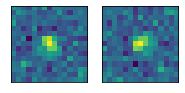

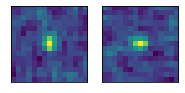

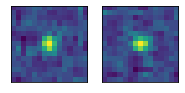

In [6]:
# OPTIONAL: Rotate the receptive fields (e.g. for asymmetric receptive fields)

def rotate_RF(aligned_RF, rotation_angles = [], plot = False):

    ''' Takes center-aligned RF. Assumes the center of an odd-number length array is the peak of the RF.
        Rotates each RF by the angle given in the array rotation_angles.
        
        - aligned_RF       :  center-aligned RFs
        - rotation_angles  :  list of rotation angles / same length as aligned_RF.shape[3]
        - plot             :  Optionally plot before and after rotation RFs
        
        Output: 
        
    '''
    
    rot_aligned_RF = np.copy(aligned_RF)
    for n in range(rot_aligned_RF.shape[3]):
        
        if plot:
            fig = plt.figure(figsize = (3,3))
            ax  = plt.subplot(121)
            indmax              = np.argmax(np.abs(rot_aligned_RF[:,:,:,n]))
            max_i, max_j, max_t = np.unravel_index(indmax, rot_aligned_RF.shape[:3]) # find the position of the peak (also in time dimension)
            plt.imshow(rot_aligned_RF[:,:,max_t,n])
            ax.set_yticks([])
            ax.set_xticks([])
        
        center  = int(np.floor(float(rot_aligned_RF.shape[0])/2.0)) # center pixel
        rot_phi = rotation_angles[n]
        scale   = 1.0
        
        M       = cv2.getRotationMatrix2D((center, center), rot_phi, scale)
        for t in np.arange(rot_aligned_RF.shape[2]):
            rot_aligned_RF[:,:,t,n] =  cv2.warpAffine(rot_aligned_RF[:,:,t,n], M, (rot_aligned_RF[:,:,t,n].shape[1], rot_aligned_RF[:,:,t,n].shape[0]))
        
        if plot:
            ax  = plt.subplot(122)
            plt.imshow(rot_aligned_RF[:,:,max_t,n])
            ax.set_yticks([])
            ax.set_xticks([])

    return rot_aligned_RF



# Just for demonstration, rot_aligned_RF is not used in the code below !
# EXAMPLE: rotate all RF by 90 degrees

rotation_angles = [90]*aligned_RF.shape[3]
rot_aligned_RF  = rotate_RF(aligned_RF, rotation_angles, plot = True)


## Get average 2D spatial RF

[Text(1, 0, '-0.25'), Text(1, 0, '0'), Text(1, 0, '0.25')]

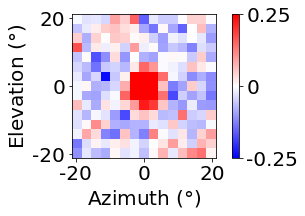

In [7]:
def get_spatialRF_2D(aligned_RF):
    indmax              = np.argmax(np.abs(aligned_RF.mean(3)))
    max_i, max_j, max_t = np.unravel_index(indmax, aligned_RF.mean(3).shape) # find the position of the peak (also in time dimension)
    spatial_RF          = aligned_RF[:,:,max_t-1:max_t+2,:].mean(2) # mean at 50ms around peak
    spatial_RF          = spatial_RF/np.abs(spatial_RF).max((0,1))[np.newaxis,np.newaxis,:]
    
    return spatial_RF

spatial_RF = get_spatialRF_2D(aligned_RF).mean(2)

# show 2D spatial RF
fig = plt.figure(figsize = (3, 3))
ax  = plt.subplot(111)

img = plt.imshow(spatial_RF, vmin = -0.25, vmax = 0.25, cmap = 'bwr')

ax.set_yticks([N_pixels - 20/(180/64.), N_pixels, N_pixels + 20/(180/64.)]) # pixel width in degree = 180° / 64 pixels
ax.set_xticks([N_pixels - 20/(180/64.), N_pixels, N_pixels + 20/(180/64.)]) # pixel width in degree = 180° / 64 pixels
ax.set_yticklabels([20, 0, -20], fontsize = 20)
ax.set_xticklabels([-20, 0, 20], fontsize = 20)

sb.despine(ax = ax, top = False, right = False)

ax.set_xlabel('Azimuth ($\degree$)', fontsize = 20)
ax.set_ylabel('Elevation ($\degree$)', fontsize = 20)

cb       = plt.colorbar(img, fraction=0.043, pad=0.1, ticks=[-0.25, 0, 0.25])
cb.ax.set_yticklabels([-0.25,0,0.25])
ticklabs = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabs, fontsize=20)